### Numpy and Torch

In [4]:
import torch
import numpy as np

In [6]:
np_data = np.arange(6).reshape((2, 3))
torch_data = torch.from_numpy(np_data)
tensor2array = torch_data.numpy()
print(
    '\nnumpy array:', np_data,
    '\ntorch tensor:', torch_data,
    '\ntensor to array:', tensor2array,
)


numpy array: [[0 1 2]
 [3 4 5]] 
torch tensor: tensor([[0, 1, 2],
        [3, 4, 5]], dtype=torch.int32) 
tensor to array: [[0 1 2]
 [3 4 5]]


- Pytorch中的数据格式是teosor格式的，可以与numpy数据相互转换

### Variable
存放会变化的值的地理位置

In [7]:
from torch.autograd import Variable
tensor = torch.FloatTensor([[1, 2], [3, 4]])
# requires_grad是参不参与误差反向传播, 要不要计算梯度
variable = Variable(tensor, requires_grad=True)
print(tensor)
print(variable)

tensor([[1., 2.],
        [3., 4.]])
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [8]:
t_out = torch.mean(tensor * tensor)
v_out = torch.mean(variable * variable)
print(t_out)
print(v_out)

tensor(7.5000)
tensor(7.5000, grad_fn=<MeanBackward1>)


In [9]:
v_out.backward()
print(variable.grad)

tensor([[0.5000, 1.0000],
        [1.5000, 2.0000]])


- Variable 计算时, 它在背景幕布后面一步步默默地搭建着一个庞大的系统, 叫做计算图, computational graph. 

计算图将所有的计算步骤 (节点) 都连接起来, 最后进行误差反向传递的时候, 一次性将所有 variable 里面的修改幅度 (梯度) 都计算出来, 而 tensor 就没有这个能力。  
v_out = torch.mean(variable*variable) 就是在计算图中添加的一个计算步骤, 计算误差反向传递的时候有他一份功劳。其过程如下：

In [10]:
# v_out = 1/4 * sum(variable*variable) 这是计算图中的 v_out 计算步骤
# 针对于 v_out 的梯度就是, d(v_out)/d(variable) = 1/4*2*variable = variable/2

- 转换格式

In [12]:
print(variable)
print(variable.data)
print(variable.data.numpy())

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[1., 2.],
        [3., 4.]])
[[ 1.  2.]
 [ 3.  4.]]


### torch的激励函数
激励函数目的在于将搭建的线性网络重新转换到非线性的现实情境之中。

C:\Users\Tiny\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\Tiny\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


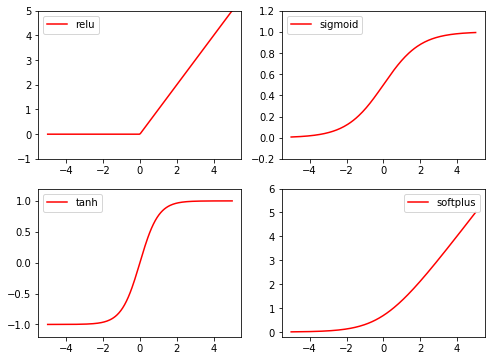

In [13]:
import torch.nn.functional as F 
x = torch.linspace(-5, 5, 200)
x = Variable(x) 
x_np = x.data.numpy()

y_relu = F.relu(x).data.numpy()
y_sigmoid = F.sigmoid(x).data.numpy()
y_tanh = F.tanh(x).data.numpy()
y_softplus = F.softplus(x).data.numpy()

# 可视化
import matplotlib.pyplot as plt 

plt.figure(1, figsize=(8, 6))
plt.subplot(221)
plt.plot(x_np, y_relu, c='red', label='relu')
plt.ylim((-1, 5))
plt.legend(loc='best')

plt.subplot(222)
plt.plot(x_np, y_sigmoid, c='red', label='sigmoid')
plt.ylim((-0.2, 1.2))
plt.legend(loc='best')

plt.subplot(223)
plt.plot(x_np, y_tanh, c='red', label='tanh')
plt.ylim((-1.2, 1.2))
plt.legend(loc='best')

plt.subplot(224)
plt.plot(x_np, y_softplus, c='red', label='softplus')
plt.ylim((-0.2, 6))
plt.legend(loc='best')

plt.show()

### 关系拟合(回归)

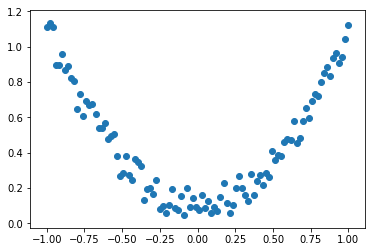

In [14]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(2) + 0.2 * torch.rand(x.size())

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

- 建立神经网络

In [16]:
class Net(torch.nn.Module): # 继承
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden) # 隐藏层线性输出
        self.predict = torch.nn.Linear(n_hidden, n_output) # 输出层线性输出
        
    # 正向传播
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)
print(net)

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


以上网络是最简单的三层神经网络，为1-10-1结构，hidden层为$h_i=in*W_i(i=1,2,...10)$，output层为$out=\sum{h_i*W_i}$

- 训练网络

In [29]:
# optimizer是训练的工具
optimizer = torch.optim.SGD(net.parameters(), lr=0.2) # 传入net的所有参数，学习率
loss_func = torch.nn.MSELoss() # 预测值和真实值的误差计算公式
for t in range(100):
    prediction = net(x) # 输入训练数据，输出预测值
    loss = loss_func(prediction, y)
    optimizer.zero_grad() # 清空上一步残余更新参数值
    loss.backward()   # 误差反向传播，计算参数更新值
    optimizer.step()  # 将参数更新值施加到net的parameters上

- optim.SGD：神经网络优化器，主要是为了优化我们的神经网络，使他在我们的训练过程中快起来，节省社交网络训练的时间。
    - 要使用torch.optim，您必须构造一个optimizer对象。这个对象能保存当前的参数状态并且基于计算梯度更新参数
    - 要构造一个Optimizer，你必须给它一个包含参数（必须都是Variable对象）进行优化。然后，您可以指定optimizer的参数选项，比如学习率，权重衰减等
    - SGD是最基础的优化方法，普通的训练方法, 需要重复不断的把整套数据放入神经网络NN中训练, 这样消耗的计算资源会很大.当我们使用SGD会把数据拆分后再分批不断放入 NN 中计算. 每次使用批数据, 虽然不能反映整体数据的情况, 不过却很大程度上加速了 NN 的训练过程, 而且也不会丢失太多准确率.
    - Adam 计算m 时有 momentum 下坡的属性, 计算 v 时有 adagrad 阻力的属性, 然后再更新参数时 把 m 和 V 都考虑进去. 实验证明, 大多数时候, 使用 adam 都能又快又好的达到目标, 迅速收敛.
- nn.MSELoss：均方损失函数。$Loss(x_i,y_i)=(x_i-y_i)^2$
- net.parameters()：构建好神经网络后，网络的参数都保存在parameters()函数当中
-  torch 中的参数初始化, 默认uniform distribution 初始化

- 可视化训练过程

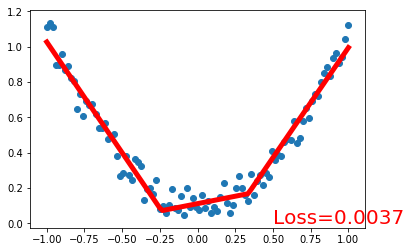

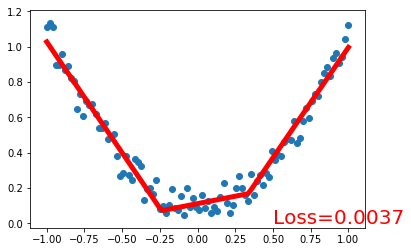

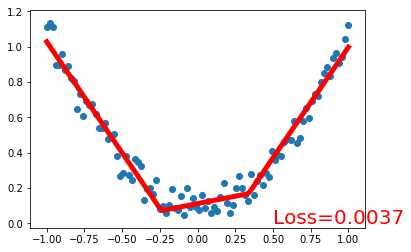

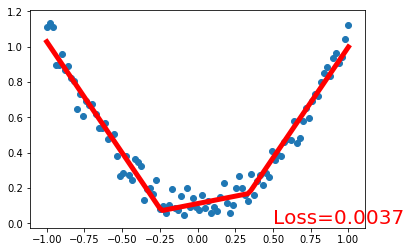

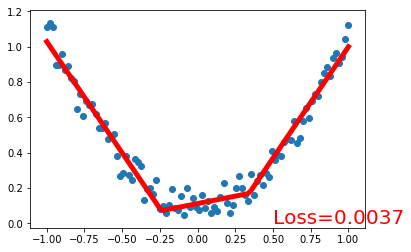

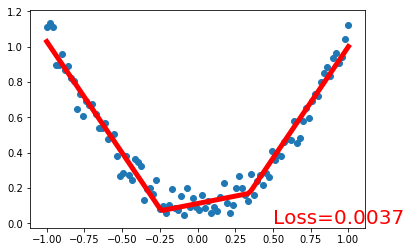

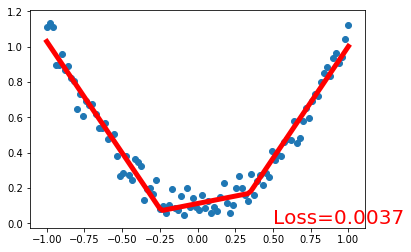

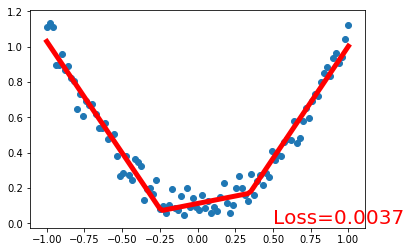

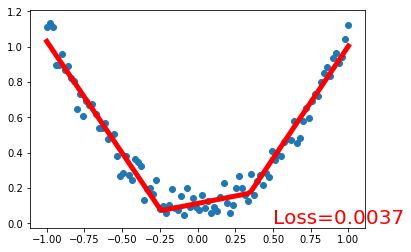

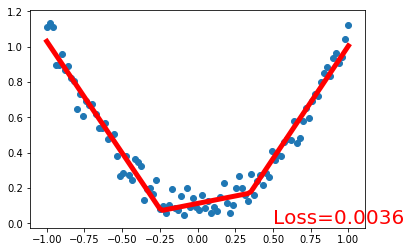

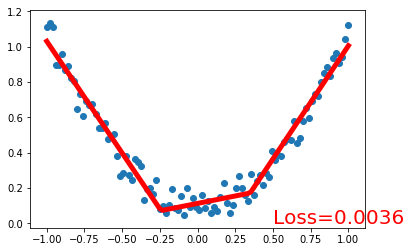

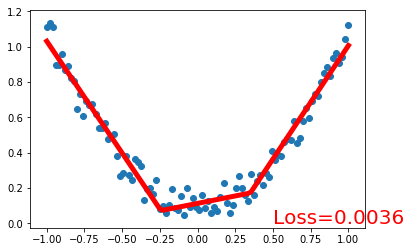

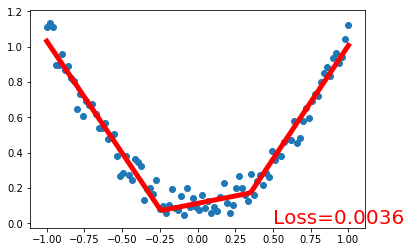

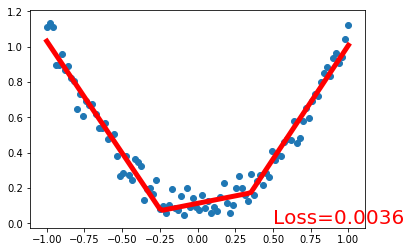

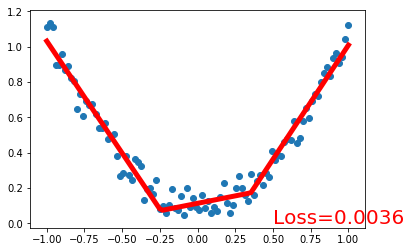

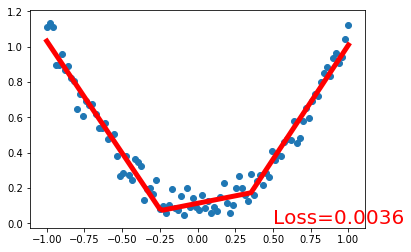

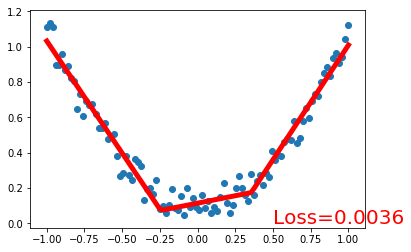

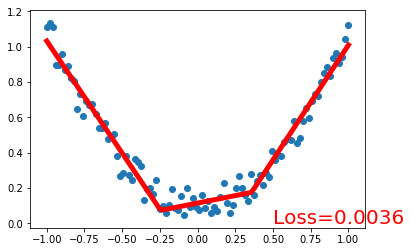

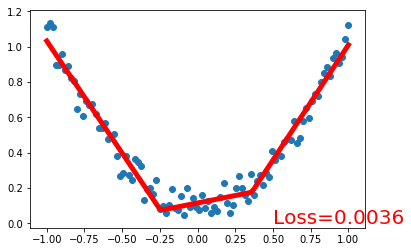

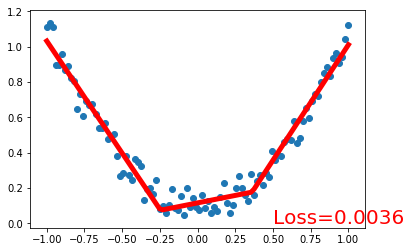

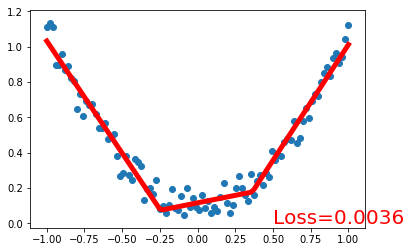

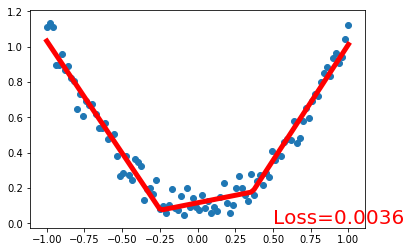

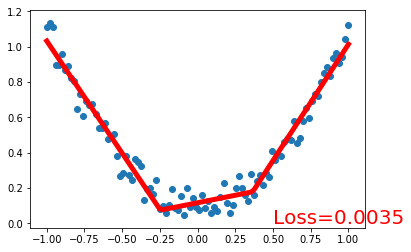

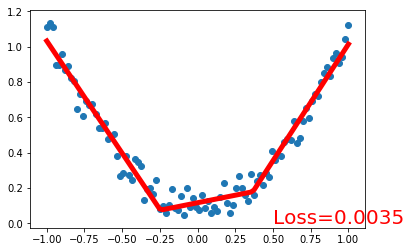

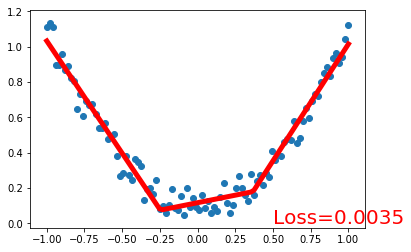

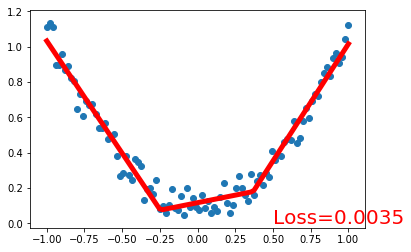

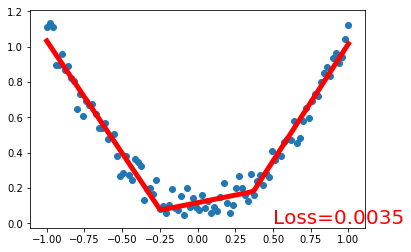

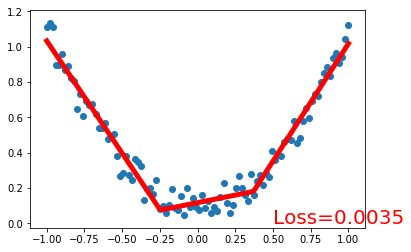

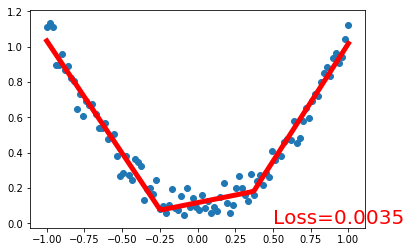

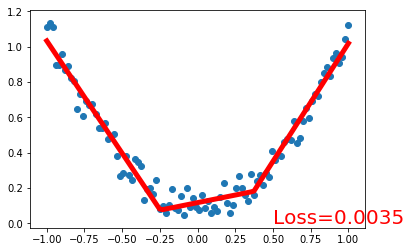

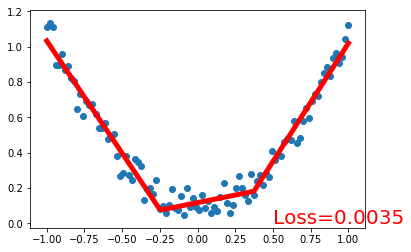

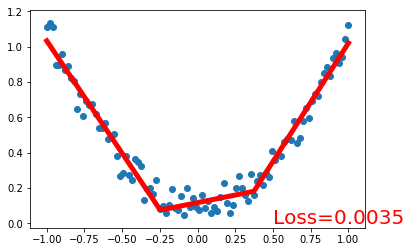

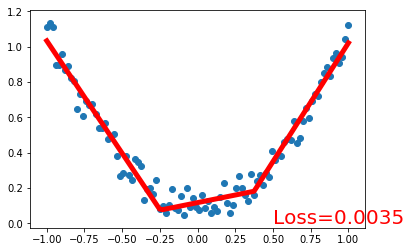

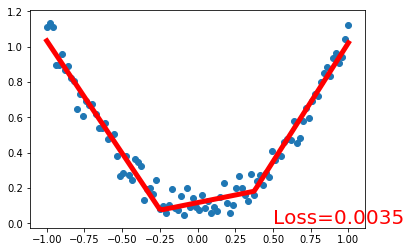

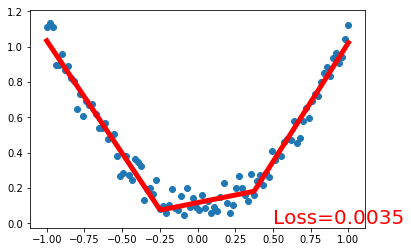

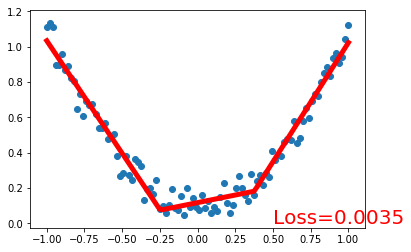

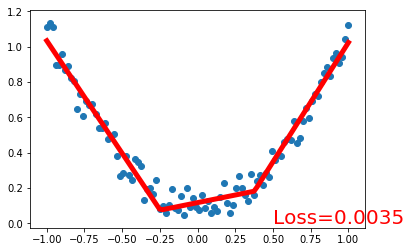

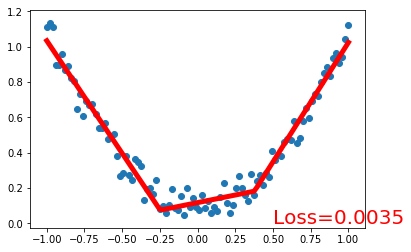

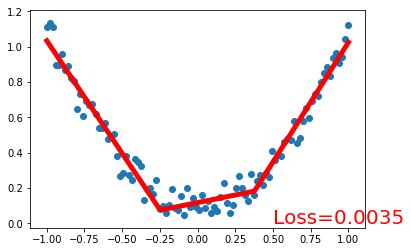

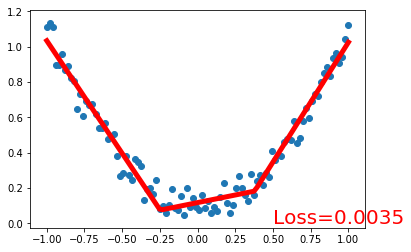

In [33]:
import matplotlib.pyplot as plt

optimizer = torch.optim.SGD(net.parameters(), lr=0.2) # 传入net的所有参数，学习率
loss_func = torch.nn.MSELoss() # 预测值和真实值的误差计算公式

plt.ion()   # 画图
plt.show()

for t in range(200):
    prediction = net(x) # 输入训练数据，输出预测值
    loss = loss_func(prediction, y)
    optimizer.zero_grad() # 清空上一步残余更新参数值
    loss.backward()   # 误差反向传播，计算参数更新值
    optimizer.step()  # 将参数更新值施加到net的parameters上
    # 接着上面来
    if t % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)